In [4]:
import os
import glob
import torch
import torch.nn as nn
import xarray as xr
import numpy as np


In [2]:

class UNet8x(nn.Module):
    def __init__(self):
        super(UNet8x, self).__init__()
        
        # Elevation Downsampling Block (to match variable resolution)
        self.downsample_elevation = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 2x downsampling
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 2x downsampling (total 4x)
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 2x downsampling (total 8x)
            nn.ReLU(inplace=True),
        )

        # Define encoding layers
        self.encoder1 = self.conv_block(65, 64)  # 32 (from elevation) + 1 (variable)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        
        # Define decoding layers
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(256 + 256, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(128 + 128, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(64 + 64, 64)
        
        # Additional upsampling layers for 8x resolution
        self.upconv_final1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 2x
        self.upconv_final2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 4x
        self.upconv_final3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 8x
        self.output = nn.Conv2d(64, 1, kernel_size=1)  # Final output layer
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, variable, elevation):  
        # Downsample elevation data to match variable resolution
        elevation_downsampled = self.downsample_elevation(elevation)

        # Check dimensions
        assert variable.shape[2:] == elevation_downsampled.shape[2:], \
            f"Selected variable and elevation dimensions do not match, {variable.shape[2:], elevation_downsampled.shape[2:]}"

        # Concatenate the two inputs
        x = torch.cat((variable, elevation_downsampled), dim=1)  
        
        # Encoder
        e1 = self.encoder1(x)  
        p1 = self.pool(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool(e3)
        
        # Bottleneck
        b = self.bottleneck(p3)
        
        # Decoder
        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)  # Skip connection
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)  # Skip connection
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)  # Skip connection
        d1 = self.decoder1(d1)
        
        # Additional upsampling for 8x resolution
        d_final1 = self.upconv_final1(d1)
        d_final2 = self.upconv_final2(d_final1)
        d_final3 = self.upconv_final3(d_final2)
        return self.output(d_final3)


In [29]:
data_path = "/Users/fquareng/data/"
dem_path = "dem_squares"
target_path = "1h_2D_sel_cropped_gridded_clustered_threshold/cluster_7/"
source_path = "1h_2D_sel_cropped_gridded_clustered_threshold_blurred/cluster_7/"
source_files = sorted(glob.glob(os.path.join(data_path, source_path, "6_5_lffd20101113050000_blurred_x8.nz")))
target_files = sorted(glob.glob(os.path.join(data_path, target_path, "6_5_lffd20101113050000.nz")))
ds = xr.open_mfdataset(source_files)
t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])

elev = xr.open_mfdataset(os.path.join(data_path, dem_path, "6_5_*"))["HSURF"]


In [37]:
model_path = "/Users/fquareng/models/UNet_x8_on_7.pth"
model = UNet8x()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model.to(device)

input_data = torch.tensor(t2m.values).float().unsqueeze(0).unsqueeze(0).to(device) # Add batch dimension
elev_data = torch.tensor(elev.values).float().unsqueeze(0).unsqueeze(0).to(device)


/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_35560/3572064039.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

In [39]:
with torch.no_grad():
    output = model(variable=input_data, elevation=elev_data)
predicted_output = output.squeeze().cpu().numpy()

predicted_output.shape

(128, 128)

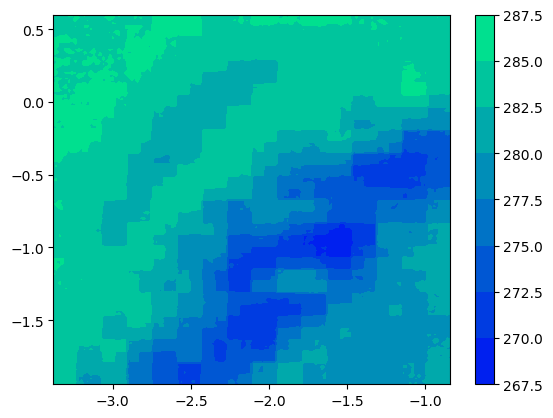

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

target_files = sorted(glob.glob(os.path.join(data_path, target_path, "6_5_lffd20101113050000.nz")))
ds = xr.open_mfdataset(target_files)
t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])

fig, ax = plt.subplots()
p = plt.contourf(t2m.rlon, t2m.rlat, predicted_output, cmap="winter")
p.set_clim(vmin=np.min(t2m).values, vmax=np.max(t2m).values)
plt.colorbar()

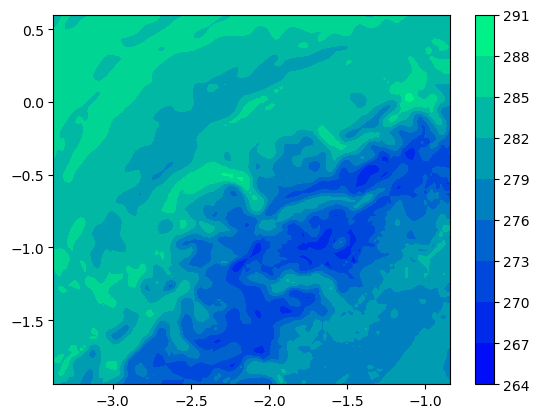

In [67]:
plt.contourf(t2m.rlon, t2m.rlat, t2m, cmap="winter")
plt.colorbar()

In [71]:
diff = t2m - predicted_output
squared_diff = diff**2
mse = squared_diff.mean().values
mse

array(2.3688111, dtype=float32)

In [ ]:
target_path = "1h_2D_sel_cropped_gridded_clustered_threshold/cluster_1/"
source_path = "1h_2D_sel_cropped_gridded_clustered_threshold_blurred/cluster_1/"
source_files = sorted(glob.glob(os.path.join(data_path, source_path, "6_5_lffd20110129140000_blurred_x8.nz")))
ds = xr.open_mfdataset(source_files)
t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])



In [78]:
model_path = "/Users/fquareng/models/UNet_x8_on_7.pth"
model = UNet8x()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model.to(device)

input_data = torch.tensor(t2m.values).float().unsqueeze(0).unsqueeze(0).to(device) # Add batch dimension
elev_data = torch.tensor(elev.values).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(variable=input_data, elevation=elev_data)
predicted_output = output.squeeze().cpu().numpy()

predicted_output.shape


/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_35560/2750945216.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

(128, 128)

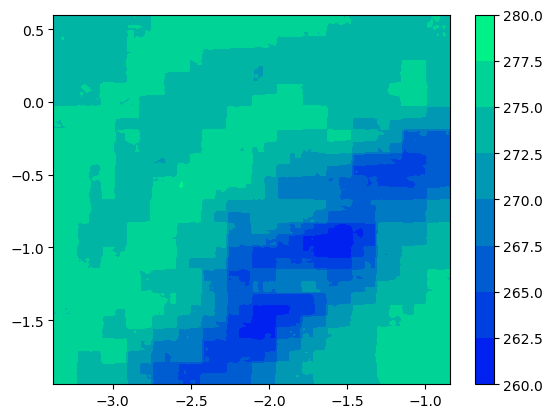

In [80]:
import matplotlib.pyplot as plt
import numpy as np

target_files = sorted(glob.glob(os.path.join(data_path, target_path, "6_5_lffd20110129140000.nz")))
ds = xr.open_mfdataset(target_files)
t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])

fig, ax = plt.subplots()
p = plt.contourf(t2m.rlon, t2m.rlat, predicted_output, cmap="winter")
p.set_clim(vmin=np.min(t2m).values, vmax=np.max(t2m).values)
plt.colorbar()

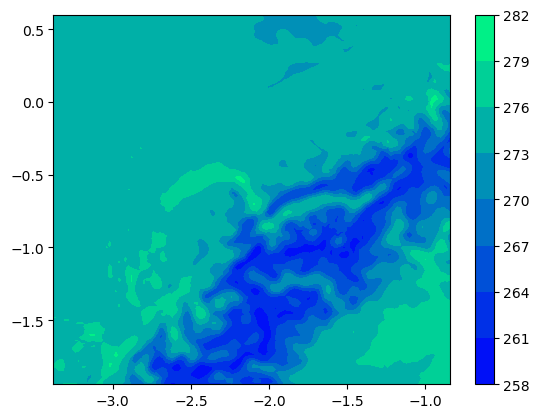

In [81]:
plt.contourf(t2m.rlon, t2m.rlat, t2m, cmap="winter")
plt.colorbar()

In [82]:
diff = t2m - predicted_output
squared_diff = diff**2
mse = squared_diff.mean().values
mse

array(3.4673429, dtype=float32)

# All


In [5]:
data_path = "/Users/fquareng/data/"
dem_path = "dem_squares"
target_path = "1h_2D_sel_cropped_gridded_clustered_threshold/cluster_7/"
source_path = "1h_2D_sel_cropped_gridded_clustered_threshold_blurred/cluster_7/"
source_files = sorted(glob.glob(os.path.join(data_path, source_path, "6_5*.nz")))
target_files = sorted(glob.glob(os.path.join(data_path, target_path, "6_5*.nz")))

model_path = "/Users/fquareng/models/UNet_x8_on_7.pth"
model = UNet8x()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model.to(device)

mse_list = []
for source_path, target_path in zip(source_files, target_files):
    ds = xr.open_dataset(source_path)

    t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])
    elev = xr.open_mfdataset(os.path.join(data_path, dem_path, "6_5_*"))["HSURF"]

    

    input_data = torch.tensor(t2m.values).float().unsqueeze(0).unsqueeze(0).to(device) # Add batch dimension
    elev_data = torch.tensor(elev.values).float().unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(variable=input_data, elevation=elev_data)
    predicted_output = output.squeeze().cpu().numpy()

    ds = xr.open_mfdataset(target_path)
    target = ds["T_2M"].sel(time=ds["T_2M"].time[0])

    diff = target - predicted_output
    squared_diff = diff**2
    mse = squared_diff.mean().values
    mse_list.append(mse)

np.mean(mse_list)

/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_40017/2956895374.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

np.float32(2.4749296)

In [6]:
data_path = "/Users/fquareng/data/"
dem_path = "dem_squares"
target_path = "1h_2D_sel_cropped_gridded_clustered_threshold/cluster_1/"
source_path = "1h_2D_sel_cropped_gridded_clustered_threshold_blurred/cluster_1/"
source_files = sorted(glob.glob(os.path.join(data_path, source_path, "6_5*.nz")))
target_files = sorted(glob.glob(os.path.join(data_path, target_path, "6_5*.nz")))

model_path = "/Users/fquareng/models/UNet_x8_on_7.pth"
model = UNet8x()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model.to(device)

mse_list = []
for source_path, target_path in zip(source_files, target_files):
    ds = xr.open_dataset(source_path)

    t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])
    elev = xr.open_mfdataset(os.path.join(data_path, dem_path, "6_5_*"))["HSURF"]

    

    input_data = torch.tensor(t2m.values).float().unsqueeze(0).unsqueeze(0).to(device) # Add batch dimension
    elev_data = torch.tensor(elev.values).float().unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(variable=input_data, elevation=elev_data)
    predicted_output = output.squeeze().cpu().numpy()

    ds = xr.open_mfdataset(target_path)
    target = ds["T_2M"].sel(time=ds["T_2M"].time[0])

    diff = target - predicted_output
    squared_diff = diff**2
    mse = squared_diff.mean().values
    mse_list.append(mse)

np.mean(mse_list)

/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_40017/2016240210.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

KeyboardInterrupt: 

In [ ]:
data_path = "/Users/fquareng/data/"
dem_path = "dem_squares"
target_path = "1h_2D_sel_cropped_gridded_clustered_threshold/cluster_1/"
source_path = "1h_2D_sel_cropped_gridded_clustered_threshold_blurred/cluster_1/"
source_files = sorted(glob.glob(os.path.join(data_path, source_path, "8_3*.nz")))
target_files = sorted(glob.glob(os.path.join(data_path, target_path, "8_3*.nz")))

model_path = "/Users/fquareng/models/UNet_x8_on_7.pth"
model = UNet8x()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model.to(device)

mse_list = []
for source_path, target_path in zip(source_files, target_files):
    ds = xr.open_dataset(source_path)

    t2m = ds["T_2M"].sel(time=ds["T_2M"].time[0])
    elev = xr.open_mfdataset(os.path.join(data_path, dem_path, "8_3_*"))["HSURF"]

    input_data = torch.tensor(t2m.values).float().unsqueeze(0).unsqueeze(0).to(device) # Add batch dimension
    elev_data = torch.tensor(elev.values).float().unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(variable=input_data, elevation=elev_data)
    predicted_output = output.squeeze().cpu().numpy()

    ds = xr.open_mfdataset(target_path)
    target = ds["T_2M"].sel(time=ds["T_2M"].time[0])

    diff = target - predicted_output
    squared_diff = diff**2
    mse = squared_diff.mean().values
    mse_list.append(mse)

np.mean(mse_list)

/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_40017/3717512365.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,